In [1]:
import numpy as np
import sounddevice as sd
from scipy.io.wavfile import write
from matplotlib import pyplot as plt
import SciFiReaders as sr
from ipywidgets import Button, HBox, VBox, Output
from IPython.display import display, clear_output
import time
import threading

%matplotlib widget

In [2]:
file_path = 'data/never_ATECCONTSPL_lockinfreq4000Hz_normgain1_ampgain10_0052.f.dy.ch1'
# file_path = 'data/letitbe_ATECCONTSPL_lockinfreq4000Hz_0021.f.dy.ch1'

data_translator = sr.WSxM2DReader(file_path)
datasets = data_translator.read()

for chan, data in datasets.items():
    # print(chan, data.quantity, data.direction)
    if data.quantity == 'Normal force':
        normalforce_data = data 
    if data.quantity == 'Amplitude':
        amplitude_data = data 



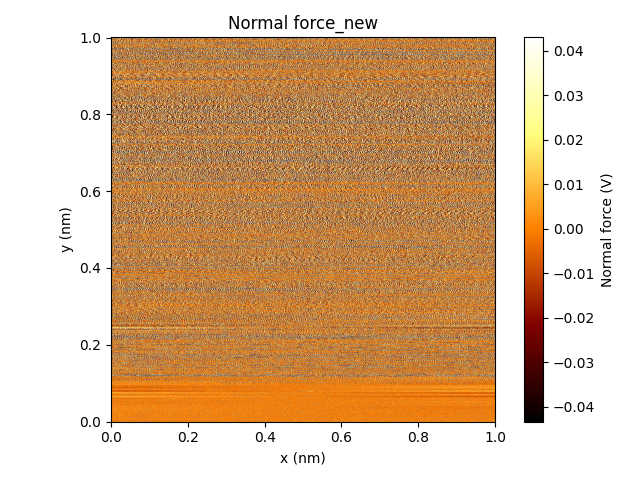

In [9]:
input_data = normalforce_data #normalforce_data, amplitude_data

if input_data.metadata['Y scanning direction [General Info]'] == 'Down':
    input_data = np.flip(input_data, axis=1)

offset = np.atleast_2d(np.median(input_data, axis=0))#.T
input_data_flattened = input_data-offset

plt.close('all')
input_data_flattened.plot(cmap='afmhot', vmin=np.percentile(input_data_flattened.compute().flatten(), 10), 
                          vmax=np.percentile(input_data_flattened.compute().flatten(), 90))
plt.show()

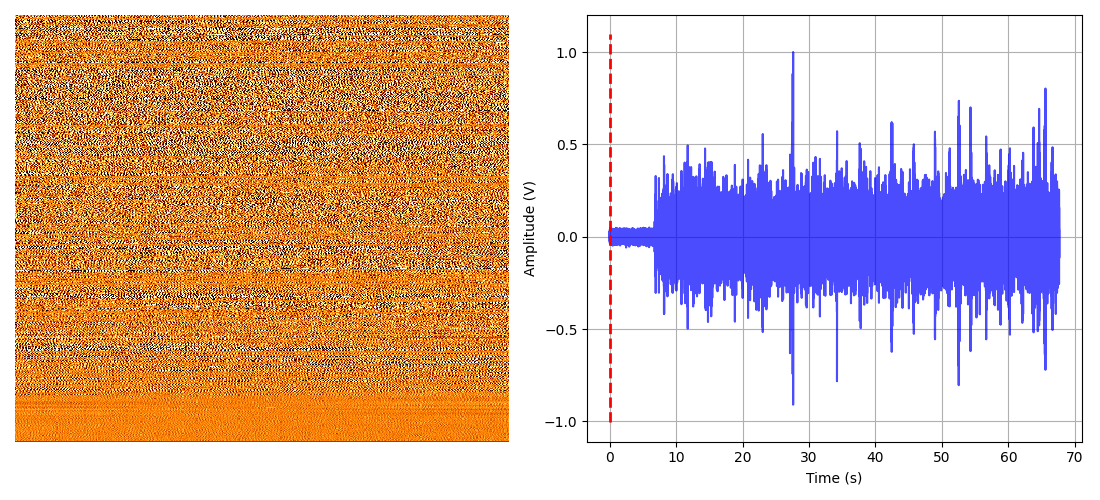

In [10]:
plt.close('all')
# --- Global Variables ---
# These variables are used to share state between different functions and threads.
stream = None  # Holds the sounddevice audio stream
fig = None     # Matplotlib figure object
ax = None      # Matplotlib axes object
line = None    # Matplotlib Line2D object for the audio waveform
cursor = None  # Matplotlib Line2D object for the playback cursor on lineplot
cursor2 = None  # Matplotlib Line2D object for the playback cursor on image
audio_data_global = None  # Stores the NumPy array with audio data
samplerate_global = None  # Stores the sample rate of the audio data
current_frame_global = 0  # Tracks the current playback position in frames
is_playing = threading.Event() # Event flag to signal if audio is currently playing
plot_update_thread = None # Reference to the thread that updates the plot
output_plot = Output()    # ipywidgets Output widget to manage plot display

# --- Audio Data Generation Function ---
def create_audio_data():
    """
    Generates a simple sine wave audio array for demonstration purposes.

    Args:
        duration (int): Duration of the audio in seconds.
        samplerate (int): Number of samples per second (Hz).
        frequency (int): Base frequency of the sine wave in Hz.

    Returns:
        tuple: A tuple containing the audio NumPy array (float32) and the samplerate.
    """
    # # Create a time array from 0 to duration
    # t = np.linspace(0., duration, int(samplerate * duration), endpoint=False)
    # amplitude = 0.5
    # # Generate a sine wave with the specified frequency and add a second harmonic
    # audio_array = amplitude * (np.sin(2 * np.pi * frequency * t) + np.sin(2 * np.pi * frequency * 1.5 * t))
    # # Ensure the audio data is in float32 format, which sounddevice expects
    # audio_array = audio_array.astype(np.float32)
    samplerate = 15500 #scanline_freq*num_pts*2 #16000

    audio_array = np.flip(input_data_flattened.compute().transpose().flatten()) #normalforce_data #0.5 * np.sin(2 * np.pi * 440 * t).astype(np.float32)
    # Normalize if the signal is outside [-1, 1]
    max_val = np.max(np.abs(audio_array))
    # if max_val > 1.0:
    audio_array = audio_array / max_val
    
    duration_seconds = len(audio_array) / samplerate
    # print(duration_seconds)
    return audio_array, samplerate


# --- Sounddevice Audio Callback Function ---
def audio_callback(outdata, frames, time_info, status):
    """
    Callback function for the sounddevice OutputStream.
    This function is called by sounddevice whenever it needs new audio data.
    It updates `current_frame_global` to track playback progress.

    Args:
        outdata (numpy.ndarray): The buffer to fill with audio data.
        frames (int): The number of frames (samples) requested by sounddevice.
        time_info (sd.CallbackGetTime): Timing information for the callback.
        status (sd.CallbackFlags): Status flags (e.g., underflow, overflow).
    """
    global current_frame_global, audio_data_global, is_playing

    if status:
        # Print any status warnings from sounddevice (e.g., buffer underrun/overrun)
        print(f"Sounddevice status: {status}")

    # Determine the start and end indices for the current audio chunk
    chunk_start = current_frame_global
    chunk_end = min(current_frame_global + frames, len(audio_data_global))
    
    # Copy audio data to the output buffer.
    # .reshape(-1, 1) is used to ensure the data has 1 channel (mono) as expected by sounddevice.
    outdata[:chunk_end - chunk_start] = audio_data_global[chunk_start:chunk_end].reshape(-1, 1)
    
    # If the amount of data copied is less than the requested `frames`,
    # it means we've reached the end of the audio array.
    if chunk_end - chunk_start < frames:
        # Fill the rest of the output buffer with zeros to prevent audio artifacts
        outdata[chunk_end - chunk_start:] = 0
        # Signal that playback has finished by clearing the 'is_playing' event
        is_playing.clear()
        # Set current_frame_global to the end of the audio to correctly position the cursor
        current_frame_global = len(audio_data_global)
        # Raise sd.CallbackStop to tell sounddevice to stop the stream after this chunk
        raise sd.CallbackStop
    
    # Update the global frame counter by the number of frames processed in this chunk
    current_frame_global += frames

# --- Plotting Functions ---
def create_plot():
    """
    Initializes the Matplotlib plot with the audio waveform and an initial cursor.
    This function also manages displaying the plot within the `output_plot` widget.
    """
    global fig, ax, line, cursor, cursor2, audio_data_global, samplerate_global
    
    # Create a new Matplotlib figure and axes
    fig, ax = plt.subplots(1,2, figsize=(11, 5))

    ax[0].pcolormesh(np.flip(input_data_flattened.compute().T, axis=0), 
                     cmap='afmhot', vmin=np.percentile(audio_data_global, 10), vmax=np.percentile(audio_data_global, 90))
    cursor2, = ax[0].plot([0, input_data_flattened.shape[0]], [0, 0], color='red', linestyle='-', lw=2)
    ax[0].set_axis_off()
    # Create the time axis for plotting the waveform
    time_axis = np.arange(len(audio_data_global)) / samplerate_global
    
    # Plot the audio waveform. `line, =` unpacks the single Line2D object returned by plot.
    line, = ax[1].plot(time_axis, audio_data_global, color='blue', alpha=0.7)
    
    # Initialize the vertical cursor line at time 0
    # The y-limits are taken from the current plot view to ensure the line spans the full height.
    cursor, = ax[1].plot([0, 0], [ax[1].get_ylim()[0], ax[1].get_ylim()[1]], color='red', linestyle='--', lw=2)
    
    # ax[1].set_title("Audio Waveform")
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Amplitude (V)")
    ax[1].grid(True)
    plt.tight_layout() # Adjust layout to prevent labels/titles from overlapping
    
    # Clear any previous content in the `output_plot` widget and display the new figure's canvas.
    # This is important for ensuring the plot is rendered correctly in Jupyter.
    with output_plot:
        clear_output(wait=True) # `wait=True` prevents flickering by clearing only after new output is ready
        display(fig.canvas) # Display the Matplotlib canvas within the Output widget

def update_plot_cursor():
    """
    This function runs in a separate thread and periodically updates the cursor's
    position on the plot based on the global `current_frame_global`.
    """
    global current_frame_global, samplerate_global, cursor, cursor2, is_playing, fig

    # Loop as long as the 'is_playing' event is set (i.e., audio is playing)
    while is_playing.is_set():
        if cursor is not None and fig is not None:
            # Calculate the current playback time in seconds
            x_pos_time = current_frame_global / samplerate_global
            
            # Update the x-data of the cursor line.
            # Matplotlib's `Line2D.set_xdata` updates the data without redrawing immediately.
            cursor.set_xdata([x_pos_time, x_pos_time])
            rowlen, collen = input_data_flattened.shape
            row_current = int(current_frame_global/rowlen)
            col_current = current_frame_global % rowlen
            cursor2.set_ydata([row_current, row_current])
            # print(current_frame_global, row_current, col_current)
            # Request a redraw of the canvas.
            # `fig.canvas.draw_idle()` schedules a redraw when the Matplotlib GUI event loop is idle.
            # `fig.canvas.flush_events()` forces a redraw on some backends.
            # For smooth animation, `%matplotlib widget` (ipympl) is highly recommended.
            try:
                fig.canvas.draw_idle()
                # On some systems/backends, flush_events helps ensure the update is visible
                # fig.canvas.flush_events() 
            except Exception as e:
                # Catch potential errors if the canvas cannot be updated from this thread
                # print(f"Error updating plot: {e}")
                pass # Silently fail if not interactive
        
        # Pause for a short duration to control the update rate (e.g., 20 times per second)
        time.sleep(0.05)

    # After playback stops, ensure the cursor is reset to the beginning (time 0)
    if cursor is not None and fig is not None:
        cursor.set_xdata([0, 0])
        cursor2.set_ydata([0, 0])
        try:
            fig.canvas.draw_idle()
            # fig.canvas.flush_events()
        except Exception:
            pass

# --- Button Callback Functions ---
def play_audio(b):
    """
    Callback function for the Play Audio button.
    Starts the sounddevice stream and the plot update thread.
    """
    global stream, audio_data_global, samplerate_global, current_frame_global, is_playing, plot_update_thread

    # Prevent starting a new stream if one is already active
    if stream and stream.is_active:
        print("Audio is already playing.")
        return

    print("Playing audio...")
    current_frame_global = 0 # Reset playback position to the start
    is_playing.set() # Set the event to indicate that audio is playing

    # Start the plot update thread if it's not already running
    if plot_update_thread is None or not plot_update_thread.is_alive():
        plot_update_thread = threading.Thread(target=update_plot_cursor)
        # Set as daemon thread so it doesn't prevent the main program from exiting
        plot_update_thread.daemon = True 
        plot_update_thread.start()

    try:
        # Initialize and start the sounddevice output stream
        # `channels=1` specifies mono audio. `dtype='float32'` matches our numpy array.
        # Added 'blocksize' for smoother playback. A larger blocksize can reduce audio dropouts
        # by giving the system more time to prepare audio chunks.
        stream = sd.OutputStream(
            samplerate=samplerate_global,
            callback=audio_callback,
            channels=1,
            dtype='float32',
            blocksize=4096 # Experiment with values like 512, 1024, 2048, or 4096 if pauses persist.
        )
        stream.start()
    except Exception as e:
        print(f"Error starting audio stream: {e}") # More specific error message
        is_playing.clear() # Clear playing flag if an error occurs

def stop_audio(b):
    """
    Callback function for the Stop Audio button.
    Stops the sounddevice stream and signals the plot update thread to stop.
    """
    global stream, is_playing, plot_update_thread
    if stream:
        print("Stopping audio...")
        is_playing.clear() # Clear the event to signal the plot update thread to stop
        try:
            stream.stop() # Stop the audio stream
            stream.close() # Close the audio stream to release resources
            print("Audio stopped.")
        except Exception as e:
            print(f"Error stopping audio: {e}")
        stream = None # Clear the stream object
        
        # Wait for the plot update thread to finish its last update and terminate
        if plot_update_thread and plot_update_thread.is_alive():
            plot_update_thread.join(timeout=1) # Give it a short time to complete
            if plot_update_thread.is_alive():
                print("Warning: Plot update thread did not terminate gracefully.")
        plot_update_thread = None # Clear the thread object
    else:
        print("No audio stream active.")

# --- Main Setup for Jupyter Notebook Cell ---

# 1. Generate initial dummy audio data
audio_data_global, samplerate_global = create_audio_data()

# 2. Create ipywidgets buttons
play_button = Button(description="Play Audio", button_style='success', icon='play')
stop_button = Button(description="Stop Audio", button_style='danger', icon='stop')

# 3. Assign the callback functions to button clicks
play_button.on_click(play_audio)
stop_button.on_click(stop_audio)

# 4. Create the initial plot. This will display the plot inside `output_plot`.
create_plot()

# 5. Arrange the buttons and the plot output widget using ipywidgets layout containers
controls = HBox([play_button, stop_button]) # Buttons horizontally
main_layout = VBox([controls]) # Controls stacked above the plot

# 6. Instructions for the user regarding Matplotlib interactivity
# print("Instructions:")
# print("1. For real-time, interactive plot updates with a smoothly moving cursor,")
# print("   please run the following in a separate Jupyter cell *before* running this code:")
# print("   `%matplotlib widget`")
# print("2. Then, run this cell to display the audio player and plot.")
# print("\nOnce the audio playback finishes or is stopped, the cursor will reset to the beginning.")

# 7. Display the final ipywidgets layout in the Jupyter output
display(main_layout)
# plt.close()